In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score

### Cargo los archivos

* Previamente los genere con las notebook subidas
* Los avisos tienen 250 columnas con las matrices 'UxE' de la salida de aplicar SVD,
    pero por ahora no las uso.
* Las vistas contienen la cantidad de vistas

In [34]:
post = pd.read_csv('/home/pcsor/facu/TP2/postulaciones.csv',low_memory=False)
avisos = pd.read_csv('/home/pcsor/facu/TP2/avisos5.csv',low_memory=False)
postulantes = pd.read_csv('/home/pcsor/facu/TP2/postulantes.csv',low_memory=False)
test = pd.read_csv('/home/pcsor/facu/TP2/test_final_100k.csv',low_memory=False)
cantidadVistas = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistas.csv',low_memory=False)
cantidadVistas15 = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistas15.csv',low_memory=False)
cantidadVistasTest = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasTest.csv',low_memory=False)
cantidadVistasTotalesPorAviso = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasTotalesPorAviso.csv',low_memory=False)
cantidadVistasPorAviso15 = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasPorAviso15.csv',low_memory=False)
cantidadVistasPorAvisoTest = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasPorAvisoTest.csv',low_memory=False)
cantidadVistasTotalesPorPostulante = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasTotalesPorPostulante.csv',low_memory=False)
cantidadVistasPorPostulante15 = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasPorPostulante15.csv',low_memory=False)
cantidadVistasPorPostulanteTest = pd.read_csv('/home/pcsor/facu/TP2/cantidadVistasPorPostulanteTest.csv',low_memory=False)

In [35]:
###### Drop a las columnas que no se utilizan
features = list(set(avisos.columns) - set(['idaviso', 'nivel_laboral','tipo_de_trabajo','nombre_area']))
avisos = avisos.drop(features,axis=1)

In [36]:
post['sepostulo'] = 1
test['sepostulo'] = 2

In [37]:
test.shape,test.columns

((100000, 4),
 Index(['id', 'idaviso', 'idpostulante', 'sepostulo'], dtype='object'))

In [38]:
##### Se arma un Trainset con dummys
train = pd.DataFrame()
train['idaviso'] = shuffle(post['idaviso'][0:7000000]).reset_index()['idaviso']
train['idpostulante'] = shuffle(post['idpostulante'][0:7000000]).reset_index()['idpostulante']
train['sepostulo'] = 0

In [39]:
##### Se controla que los dummys con '0' NO sean postulaciones reales
train = pd.merge(train, post, how='left', on=['idpostulante', 'idaviso'], indicator=True)
train = train.query('_merge != "both"')
train = train.drop(['_merge','sepostulo_y','fechapostulacion'],axis=1)
train.columns = ['idaviso','idpostulante','sepostulo']

In [40]:
##### Se controla que los dummys NO esten en las postulaciones a predecir
train = pd.merge(train, test, how='left', on=['idpostulante', 'idaviso'], indicator=True)
train = train.query('_merge != "both"')
train = train.drop(['_merge','id','sepostulo_y'],axis=1)
train.columns = ['idaviso','idpostulante','sepostulo']

In [41]:
train.columns,train.shape

(Index(['idaviso', 'idpostulante', 'sepostulo'], dtype='object'), (6456018, 3))

In [42]:
train = train.drop_duplicates(['idaviso','idpostulante'])

In [43]:
train.shape,post.shape

((6383708, 3), (6603752, 4))

In [44]:
###### Se filtran las postulaciones antiguas
post = post.sort_values(by='fechapostulacion',ascending=False)
post = post.reset_index().drop('index',axis=1)
abril = '2018-04-01 00:00:00'
post = post.loc[post['fechapostulacion']>abril]
post = post.drop(['fechapostulacion'], axis=1)
post[0:3]

,idaviso,idpostulante,sepostulo
0,1112470106,W9keddN,1
1,1112454333,ZDr9NB1,1
2,1112467020,bOjXla0,1


In [45]:
####### Se juntan los dummys con las postulaciones filtradas
train = pd.concat([train,post])
train = shuffle(train)
train = train.reset_index().drop('index',axis=1)
train = train.drop_duplicates(['idaviso','idpostulante'])

In [46]:
train = pd.concat([train,test])

In [47]:
####### Se agregan los features de los avisos
train = pd.merge(train,avisos,how='left',on='idaviso',indicator=True)
train = train.query('_merge != "left_only"')
train = train.drop(['_merge'],axis=1)
train[0:3]

,id,idaviso,idpostulante,sepostulo,tipo_de_trabajo,nombre_area,nivel_laboral
0,NaN,1112358902,W9kAmka,0,1.0,143.0,4.0
1,NaN,1112221312,Nzdzwo4,0,2.0,24.0,2.0
2,NaN,1112317812,lDwxdb1,0,1.0,115.0,4.0


In [48]:
####### Agrego la cantidad de vistas y relleno con '0' las que no son vistas
train = pd.merge(train,cantidadVistas,how='left',on=['idaviso','idpostulante',])
train['cantidadDeVistas'] = train['cantidadDeVistas'].fillna(0)

In [49]:
train = pd.merge(train,cantidadVistasTotalesPorAviso,how='left',on=['idaviso'])
train['vistasPorAvisoTotales'] = train['vistasPorAvisoTotales'].fillna(0)

In [50]:
train = pd.merge(train,cantidadVistasTotalesPorPostulante,how='left',on=['idpostulante'])
train['vistasPorPostulanteTotales'] = train['vistasPorPostulanteTotales'].fillna(0)

In [51]:
train['vistasPorPostulanteTotales'].mean(),train['vistasPorAvisoTotales'].mean(),train['cantidadDeVistas'].mean()

(100.64682868058702, 2798.5816715989804, 0.2693519768237348)

In [52]:
train[0:4]

,id,idaviso,idpostulante,sepostulo,tipo_de_trabajo,nombre_area,nivel_laboral,cantidadDeVistas,vistasPorAvisoTotales,vistasPorPostulanteTotales
0,NaN,1112358902,W9kAmka,0,1.0,143.0,4.0,0.0,376.0,53.0
1,NaN,1112221312,Nzdzwo4,0,2.0,24.0,2.0,0.0,1.0,109.0
2,NaN,1112317812,lDwxdb1,0,1.0,115.0,4.0,0.0,80.0,30.0
3,NaN,1111945045,pzdRYxL,0,1.0,86.0,2.0,0.0,99.0,0.0


In [53]:
####### Agrego los datos de los postulantes y se rellenan los NaNs con el promedio
train = pd.merge(train,postulantes,how='left',on=['idpostulante'])
train['edad'] = train['edad'].fillna(int(train['edad'].mean()))
train['nombre'] = train['nombre'].fillna(int(train['nombre'].mean()))
train = train.drop('estado',axis = 1)

In [54]:
####### Se realiza un encoding de los IDS
lb_make = LabelEncoder()
train['idpostulanteE'] = lb_make.fit_transform(train['idpostulante'] )
train['idavisoE'] = lb_make.fit_transform(train['idaviso'] )

In [55]:
test = train.loc[train['sepostulo']==2]

In [56]:
test.shape,test.columns

((100000, 15),
 Index(['id', 'idaviso', 'idpostulante', 'sepostulo', 'tipo_de_trabajo',
        'nombre_area', 'nivel_laboral', 'cantidadDeVistas',
        'vistasPorAvisoTotales', 'vistasPorPostulanteTotales', 'sexo', 'edad',
        'nombre', 'idpostulanteE', 'idavisoE'],
       dtype='object'))

In [57]:
test = test.drop('sepostulo',axis=1)
train = train.drop('id',axis=1)

In [58]:
train = train.loc[train['sepostulo'] != 2]

In [59]:
test.shape,test.columns,train.shape,train.columns

((100000, 14),
 Index(['id', 'idaviso', 'idpostulante', 'tipo_de_trabajo', 'nombre_area',
        'nivel_laboral', 'cantidadDeVistas', 'vistasPorAvisoTotales',
        'vistasPorPostulanteTotales', 'sexo', 'edad', 'nombre', 'idpostulanteE',
        'idavisoE'],
       dtype='object'),
 (7180897, 14),
 Index(['idaviso', 'idpostulante', 'sepostulo', 'tipo_de_trabajo',
        'nombre_area', 'nivel_laboral', 'cantidadDeVistas',
        'vistasPorAvisoTotales', 'vistasPorPostulanteTotales', 'sexo', 'edad',
        'nombre', 'idpostulanteE', 'idavisoE'],
       dtype='object'))

In [60]:
####### Agrego la cantidad de vistas y relleno con '0' las que no son vistas
train = pd.merge(train,cantidadVistas15,how='left',on=['idaviso','idpostulante',])
train['cantidadDeVistas15'] = train['cantidadDeVistas15'].fillna(0)
train = pd.merge(train,cantidadVistasPorAviso15,how='left',on=['idaviso'])
train['vistasPorAviso15'] = train['vistasPorAviso15'].fillna(0)
train = pd.merge(train,cantidadVistasPorPostulante15,how='left',on=['idpostulante',])
train['vistasPorPostulante15'] = train['vistasPorPostulante15'].fillna(0)

In [61]:
####### Agrego la cantidad de vistas y relleno con '0' las que no son vistas
test = pd.merge(test,cantidadVistasTest,how='left',on=['idaviso','idpostulante',])
test['cantidadDeVistas15'] = test['cantidadDeVistas15'].fillna(0)
test = pd.merge(test,cantidadVistasPorAvisoTest,how='left',on=['idaviso'])
test['vistasPorAviso15'] = test['vistasPorAviso15'].fillna(0)
test = pd.merge(test,cantidadVistasPorPostulanteTest,how='left',on=['idpostulante',])
test['vistasPorPostulante15'] = test['vistasPorPostulante15'].fillna(0)

In [64]:
test.columns,train.columns

(Index(['id', 'tipo_de_trabajo', 'nombre_area', 'nivel_laboral',
        'cantidadDeVistas', 'vistasPorAvisoTotales',
        'vistasPorPostulanteTotales', 'sexo', 'edad', 'nombre', 'idpostulanteE',
        'idavisoE', 'cantidadDeVistas15', 'vistasPorAviso15',
        'vistasPorPostulante15'],
       dtype='object'),
 Index(['sepostulo', 'tipo_de_trabajo', 'nombre_area', 'nivel_laboral',
        'cantidadDeVistas', 'vistasPorAvisoTotales',
        'vistasPorPostulanteTotales', 'sexo', 'edad', 'nombre', 'idpostulanteE',
        'idavisoE', 'cantidadDeVistas15', 'vistasPorAviso15',
        'vistasPorPostulante15'],
       dtype='object'))

In [87]:
test = test.drop(['idaviso','idpostulante','nivel_laboral','tipo_de_trabajo'],axis=1)
train = train.drop(['idaviso','idpostulante','nivel_laboral','tipo_de_trabajo'],axis=1)

,tipo_de_trabajo,nombre_area,nivel_laboral,cantidadDeVistas,vistasPorAvisoTotales,vistasPorPostulanteTotales,sexo,edad,nombre,idpostulanteE,idavisoE,cantidadDeVistas15,vistasPorAviso15,vistasPorPostulante15
sepostulo,,,,,,,,,,,,,,
0,5978370,5978370,5978370,5978370,5978370,5978370,5978370,5978370,5978370,5978370,5978370,5978370,5978370,5978370
1,1202527,1202527,1202527,1202527,1202527,1202527,1202527,1202527,1202527,1202527,1202527,1202527,1202527,1202527


In [88]:
clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)

<BarContainer object of 14 artists>

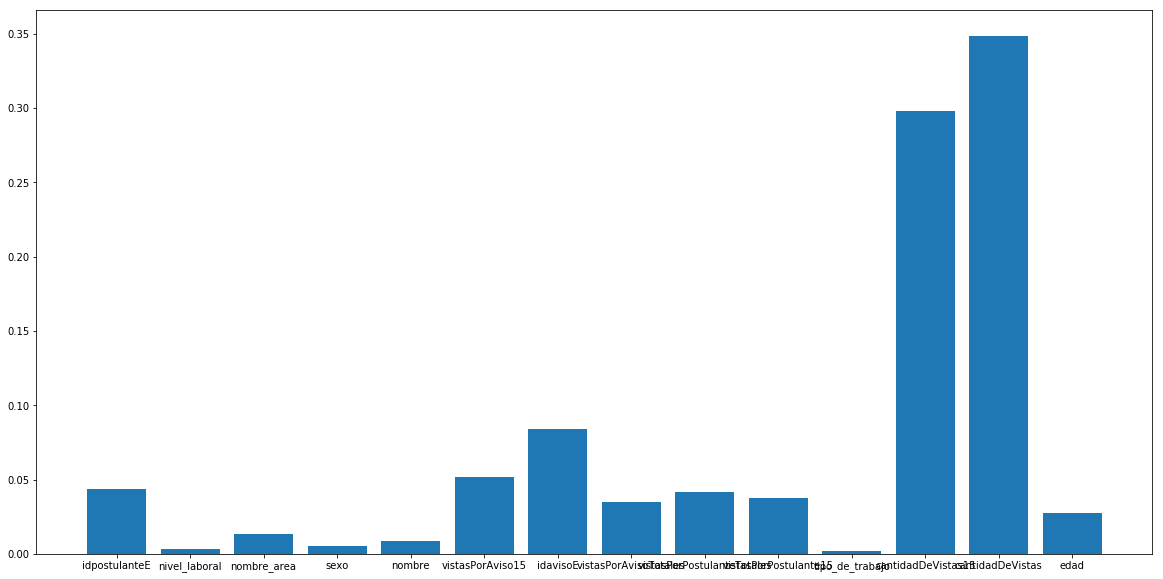

In [78]:
features = list(set(train.columns) - set(['sepostulo']))
clf.fit(train[features],train['sepostulo'])
plt.figure(figsize=(20,10))
plt.bar(train[features].columns.values,clf.feature_importances_)

In [79]:
predic = clf.predict(test.iloc[:,1:])

In [80]:
predic.mean()

0.43825

In [81]:
submit = pd.DataFrame()
submit['id'] = test['id']
submit['sepostulo'] = predic
#submit = submit.drop_duplicates('id')

In [82]:
submit['id'] = submit['id'].apply(int)

In [86]:
submit.to_csv('/home/pcsor/facu/TP2/submit1.csv',index=False)